In [ ]:
#Based on Kaggle tutorial @ https://www.kaggle.com/gspmoreira/recommender-systems-in-python-101
#More reading @ http://fastml.com/evaluating-recommender-systems/

In [42]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt

In [2]:
articles_df = pd.read_csv('data/shared_articles.csv')
articles_df = articles_df[articles_df['eventType'] == 'CONTENT SHARED']
articles_df.head(5)

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en
5,1459194522,CONTENT SHARED,-2826566343807132236,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en


In [3]:
interactions_df = pd.read_csv('data/users_interactions.csv')
interactions_df.head(10)

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN
5,1465413742,VIEW,310515487419366995,-8763398617720485024,1395789369402380392,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,MG,BR
6,1465415950,VIEW,-8864073373672512525,3609194402293569455,1143207167886864524,NaN,NaN,NaN
7,1465415066,VIEW,-1492913151930215984,4254153380739593270,8743229464706506141,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR
8,1465413762,VIEW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
9,1465413771,VIEW,3064370296170038610,3609194402293569455,1143207167886864524,NaN,NaN,NaN


In [4]:
#build model for ranking significance of interaction events

event_type_strength = {
    'VIEW' : 1.0,
    'LIKE' : 2.0,
    'BOOKMARK' : 2.5,
    'FOLLOW' : 3.0,
    'COMMENT CREATED' : 4.0,
}

interactions_df['eventStrength'] = interactions_df['eventType'].apply(lambda x: event_type_strength[x])

In [5]:
#remove users with less than 5 interationcs from dataset

users_interactions_count_df = interactions_df.groupby(['personId', 'contentId']).size().groupby('personId').size()
print('# users: %d' % len(users_interactions_count_df))

users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['personId']]
print('# users with at least 5 interactions: %d' % len(users_with_enough_interactions_df))


# users: 1895
# users with at least 5 interactions: 1140


In [6]:
print('# of interactions: %d' % len(interactions_df))
interactions_from_selected_users_df = interactions_df.merge(users_with_enough_interactions_df,
                                                           how = 'right',
                                                           left_on = 'personId',
                                                           right_on = 'personId')
print('# of interactions from users with at least 5 interactions: %d' % len(interactions_from_selected_users_df))

# of interactions: 72312
# of interactions from users with at least 5 interactions: 69868


In [7]:
# to model the user interest on a given article, we aggregate all the interactions the user has performed in an item by a weighted sum of interaction type strength and apply a log transformation to smooth the distribution.

def smooth_user_preference(x):
    return math.log(1+x, 2)

interactions_full_df = interactions_from_selected_users_df \
    .groupby(['personId', 'contentId'])['eventStrength'].sum() \
    .apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_full_df))
interactions_full_df.head(10)

# of unique user/item interactions: 39106


,personId,contentId,eventStrength
0,-9223121837663643404,-8949113594875411859,1.000000
1,-9223121837663643404,-8377626164558006982,1.000000
2,-9223121837663643404,-8208801367848627943,1.000000
3,-9223121837663643404,-8187220755213888616,1.000000
4,-9223121837663643404,-7423191370472335463,3.169925
5,-9223121837663643404,-7331393944609614247,1.000000
6,-9223121837663643404,-6872546942144599345,1.000000
7,-9223121837663643404,-6728844082024523434,1.000000
8,-9223121837663643404,-6590819806697898649,1.000000
9,-9223121837663643404,-6558712014192834002,1.584963


In [8]:
#create training and test sets for model evaluation

interactions_train_df, interactions_test_df = train_test_split(interactions_full_df,
                                                              stratify=interactions_full_df['personId'],
                                                              test_size=0.20,
                                                              random_state=42)
print('# interactions on train set: %d' % len(interactions_train_df))
print('# interactions on test set: %d' % len(interactions_test_df))


# interactions on train set: 31284
# interactions on test set: 7822


In [9]:
#indexing personId to speed up searches during evaluation

interactions_full_indexed_df = interactions_full_df.set_index('personId')
interactions_train_indexed_df = interactions_train_df.set_index('personId')
interactions_test_indexed_df = interactions_test_df.set_index('personId')


In [10]:
def get_items_interacted(person_id, interactions_df):
    #get the users data and merge in the movie information
    interacted_items = interactions_df.loc[person_id]['contentId']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [33]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:
    
    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
        all_items = set(articles_df['contentId'])
        non_interacted_items = all_items - interacted_items
        
        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)
    
    def _verify_hit_top_n(self, item_id, recommended_items, topn):
        try:
            index = next(i for i, c in enumerate(recommended_items) if c == item_id)
        except:
            index = -1
        hit = int(index in range(0, topn))
        return hit, index
    
    def evaluate_model_for_user(self, model, person_id):
        #getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        if type(interacted_values_testset['contentId']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['contentId'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['contentId'])])
        
        interacted_items_count_testset = len(person_interacted_items_testset)
        
        #getting ranked recommendation list from a model for a given user
        person_recs_df = model.recommend_items(person_id, items_to_ignore=get_items_interacted(person_id, interactions_train_indexed_df), topn=10000000000)
        
        hits_at_5_count = 0
        hits_at_10_count = 0
        
        #for each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            
            #getting a random sample(100) items the user has not interacted
            #to represent items that are assumed to be not relevant to the user
            non_interacted_items_sample = self.get_not_interacted_items_sample(
                person_id,
                sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS,
                seed=item_id%(2**32))
            
            #combining the current interacted item with 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))
             
            #Filtering only reccomendations that are either the interacted item
            #or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['contentId'].isin(items_to_filter_recs)]
            valid_recs = valid_recs_df['contentId'].values
            
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10
            
        #Recall is the rate of the interacted items that are ranked among the Top-N
        #recommended items when mixed with a set of non-recommended items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count,
                         'hits@10_count':hits_at_10_count,
                         'interacted_count': interacted_items_count_testset,
                         'recall@5':recall_at_5,
                         'recall@10':recall_at_10}

        return person_metrics
    
    def evaluate_model(self, model):
        print('running evaluation for users...')
        people_metrics = []
        
        for idx, person_id in enumerate(
            list(interactions_test_indexed_df.index.unique().values)):
            person_metrics = self.evaluate_model_for_user(model, person_id)
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
        
        print('%d users processes' % idx)
        
        detailed_results_df = pd.DataFrame(people_metrics) \
            .sort_values('interacted_count', ascending=False)
            
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName':model.get_model_name(),
                         'recall@5': global_recall_at_5,
                         'recall@10': global_recall_at_10}
        
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator()

In [34]:
#baseline approach: popularity model

item_popularity_df =  interactions_full_df.groupby('contentId')['eventStrength'].sum().sort_values(ascending=False).reset_index()
item_popularity_df.head(10)

,contentId,eventStrength
0,-4029704725707465084,307.733799
1,-6783772548752091658,233.762157
2,-133139342397538859,228.024567
3,-8208801367848627943,197.107608
4,-6843047699859121724,193.825208
5,8224860111193157980,189.044680
6,-2358756719610361882,183.110951
7,2581138407738454418,180.282876
8,7507067965574797372,179.094002
9,1469580151036142903,170.548969


In [35]:
class PopularityRecommender:
    MODEL_NAME = "Popularity"
    
    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df
    
    def get_model_name(self):
        return self.MODEL_NAME
    
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        #recommend more popular items that the user hasnt seen yet
        recommendations_df = self.popularity_df[~self.popularity_df['contentId'].isin(items_to_ignore)] \
            .sort_values('eventStrength', ascending=False).head(topn)
            
        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')
                
            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', left_on = 'contentId', right_on = 'contentId')[['eventStrength', 'contentId', 'title', 'url', 'lang']]
            
        return recommendations_df
    
popularity_model = PopularityRecommender(item_popularity_df, articles_df)

In [37]:
print('Evaluating Popularity recommendation model....')
pop_global_metrics, pop_detailed_results_df = model_evaluator.evaluate_model(popularity_model)
print('\nGlobal metrics: \n%s' % pop_global_metrics)
pop_detailed_results_df.head(10)

Evaluating Popularity recommendation model....
running evaluation for users...
1139 users processes

Global metrics: 
{'recall@5': 0.24558936333418563, 'modelName': 'Popularity', 'recall@10': 0.3738174379953976}


,_person_id,hits@10_count,hits@5_count,interacted_count,recall@10,recall@5
76,3609194402293569455,51,26,192,0.265625,0.135417
17,-2626634673110551643,27,10,134,0.201493,0.074627
16,-1032019229384696495,27,14,130,0.207692,0.107692
10,-1443636648652872475,7,4,117,0.059829,0.034188
82,-2979881261169775358,37,22,88,0.420455,0.250000
161,-3596626804281480007,23,13,80,0.287500,0.162500
65,1116121227607581999,34,21,73,0.465753,0.287671
81,692689608292948411,21,16,69,0.304348,0.231884
106,-9016528795238256703,20,14,69,0.289855,0.202899
52,3636910968448833585,27,21,68,0.397059,0.308824


In [44]:
#Build Content-based filtering model

#ignore stopwords from english and portugese
stopwords_list = stopwords.words('english') + stopwords.words('portuguese')

#Trains a model whose vector size is 5000 composed by the main unigrams and bigrams found in the corpus, ignoring stopwords
vectorizer = TfidfVectorizer(analyzer='word',
                            ngram_range=(1,2),
                            min_df=0.003,
                            max_df=0.5,
                            max_features=5000,
                            stop_words=stopwords_list)
item_ids = articles_df['contentId'].tolist()
tfidf_matrix = vectorizer.fit_transform(articles_df['title'] + "" + articles_df['text'])
tfidf_feature_names = vectorizer.get_feature_names()
tfidf_matrix

<3047x5000 sparse matrix of type '<type 'numpy.float64'>'
	with 638928 stored elements in Compressed Sparse Row format>

In [48]:
#modelling user profiles. Get all items a user has interacted with, average them weighted by strength of interaction

def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(person_id, interactions_indexed_df):
    interactions_person_df = interactions_indexed_df.loc[person_id]
    user_item_profiles = get_item_profiles(interactions_person_df['contentId'])
    
    user_item_strengths = np.array(interactions_person_df['eventStrength']).reshape(-1,1)
    #Weighted average of item profiles by the interactions strength
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
    user_profile_norm = sklearn.preprocessing.normalize(user_item_strengths_weighted_avg)
    return user_profile_norm

def build_users_profiles(): 
    interactions_indexed_df = interactions_full_df[interactions_full_df['contentId'] \
                                                   .isin(articles_df['contentId'])].set_index('personId')
    user_profiles = {}
    for person_id in interactions_indexed_df.index.unique():
        user_profiles[person_id] = build_users_profile(person_id, interactions_indexed_df)
    return user_profiles
    
user_profiles = build_users_profiles()
len(user_profiles)

1140

In [49]:
myprofile = user_profiles[-1479311724257856983]
print(myprofile.shape)
pd.DataFrame(sorted(zip(tfidf_feature_names,
                       user_profiles[-1479311724257856983].flatten().tolist()),
                   key=lambda x: -x[1])[:20], columns=['token', 'relevance'])

(1, 5000)


,token,relevance
0,learning,0.305655
1,machine learning,0.255557
2,machine,0.246095
3,google,0.208590
4,data,0.172509
5,ai,0.136818
6,algorithms,0.102396
7,graph,0.098438
8,like,0.096970
9,language,0.083993


In [55]:
class ContentBasedRecommender:
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, items_df=None):
        self.item_ids = item_ids
        self.items_df = items_df
    
    def get_model_name(self):
        return self.MODEL_NAME
    
    def _get_similar_items_to_user_profile(self, person_id, topn=1000):
        #Compute the cosine similarity between the user profile and all item profiles
        cosine_similarities = cosine_similarity(user_profiles[person_id], tfidf_matrix)
        #Gets the top similar items
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        #sort the similar items by similarity
        similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_items
    
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        #Ignores items the user has already interacted with
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        
        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['contentId', 'recStrength']).head(topn)
        recommendations_df = recommendations_df.merge(self.items_df, how='left', left_on= 'contentId', right_on='contentId')[['recStrength', 'contentId', 'title', 'url', 'lang']]
        
        return recommendations_df
    
content_based_recommender_model = ContentBasedRecommender(articles_df)
        

In [57]:
#lets see some of those recommendations...
items = pd.DataFrame(ContentBasedRecommender._get_similar_items_to_user_profile(content_based_recommender_model, person_id=-1479311724257856983))
items.head(10)

,0,1
0,5250363310227021277,0.687680
1,-7126520323752764957,0.685644
2,638282658987724754,0.627566
3,5258604889412591249,0.589825
4,-8068727428160395745,0.580010
5,2220561310072186802,0.569947
6,-229081393244987789,0.567711
7,54678605145828343,0.560292
8,-4571929941432664145,0.559810
9,-9033211547111606164,0.551734


In [53]:
print('Evaluating Content-Based Filtering model...')
cb_global_metrics, cb_detailed_results_df = model_evaluator.evaluate_model(content_based_recommender_model)
print('\nGlobal metrics:\n%s' % cb_global_metrics)
cb_detailed_results_df.head(10)

Evaluating Content-Based Filtering model...
running evaluation for users...
1139 users processes

Global metrics:
{'recall@5': 0.4125543339299412, 'modelName': 'Content-Based', 'recall@10': 0.5256967527486577}


,_person_id,hits@10_count,hits@5_count,interacted_count,recall@10,recall@5
76,3609194402293569455,23,17,192,0.119792,0.088542
17,-2626634673110551643,33,21,134,0.246269,0.156716
16,-1032019229384696495,34,18,130,0.261538,0.138462
10,-1443636648652872475,54,35,117,0.461538,0.299145
82,-2979881261169775358,15,6,88,0.170455,0.068182
161,-3596626804281480007,26,13,80,0.325000,0.162500
65,1116121227607581999,15,9,73,0.205479,0.123288
81,692689608292948411,20,9,69,0.289855,0.130435
106,-9016528795238256703,13,6,69,0.188406,0.086957
52,3636910968448833585,14,9,68,0.205882,0.132353


In [58]:
#Build collaborative filtering model
users_items_pivot_matrix_df = interactions_train_df.pivot(index='personId',
                                                         columns='contentId',
                                                         values='eventStrength').fillna(0)

users_items_pivot_matrix_df.head(10)

contentId,-9222795471790223670,-9216926795620865886,-9194572880052200111,-9192549002213406534,-9190737901804729417,-9189659052158407108,-9176143510534135851,-9172673334835262304,-9171475473795142532,-9166778629773133902,...,9191014301634017491,9207286802575546269,9208127165664287660,9209629151177723638,9209886322932807692,9213260650272029784,9215261273565326920,9217155070834564627,9220445660318725468,9222265156747237864
personId,,,,,,,,,,,,,,,,,,,,,
-9223121837663643404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9212075797126931087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9207251133131336884,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9199575329909162940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9196668942822132778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9188188261933657343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9172914609055320039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9156344805277471150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9120685872592674274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
users_items_pivot_matrix = users_items_pivot_matrix_df.as_matrix()
users_items_pivot_matrix[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 2., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [61]:
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

[-9223121837663643404,
 -9212075797126931087,
 -9207251133131336884,
 -9199575329909162940,
 -9196668942822132778,
 -9188188261933657343,
 -9172914609055320039,
 -9156344805277471150,
 -9120685872592674274,
 -9109785559521267180]

In [62]:
#The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 15
#Performs matrix factorization of the original user item matrix
U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)

In [63]:
U.shape

(1140, 15)

In [64]:
Vt.shape

(15, 2926)

In [65]:
sigma = np.diag(sigma)
sigma.shape

(15, 15)

In [66]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

array([[ 0.01039915,  0.00081872, -0.01725263, ...,  0.00140708,
         0.0110647 ,  0.00226063],
       [-0.00019285, -0.00031318, -0.00264624, ...,  0.00251658,
         0.00017609, -0.00189488],
       [-0.01254721,  0.0065947 , -0.00590676, ...,  0.00698975,
        -0.01015696,  0.01154572],
       ...,
       [-0.02995379,  0.00805715, -0.01846307, ..., -0.01083078,
        -0.00118591,  0.0096798 ],
       [-0.01845505,  0.00467019,  0.01219602, ...,  0.00409507,
         0.00019482, -0.00752562],
       [-0.01506374,  0.00327732,  0.13391269, ..., -0.01191815,
         0.06422074,  0.01303244]])

In [67]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head(10)

,-9223121837663643404,-9212075797126931087,-9207251133131336884,-9199575329909162940,-9196668942822132778,-9188188261933657343,-9172914609055320039,-9156344805277471150,-9120685872592674274,-9109785559521267180,...,9105269044962898535,9109075639526981934,9135582630122950040,9137372837662939523,9148269800512008413,9165571805999894845,9187866633451383747,9191849144618614467,9199170757466086545,9210530975708218054
contentId,,,,,,,,,,,,,,,,,,,,,
-9222795471790223670,0.010399,-0.000193,-0.012547,0.052958,-0.010035,-0.005412,-0.003918,0.049302,-0.013458,-0.020052,...,-0.005306,-0.089463,-0.000048,0.015023,0.020953,-0.009394,-0.019114,-0.029954,-0.018455,-0.015064
-9216926795620865886,0.000819,-0.000313,0.006595,-0.000649,0.000151,0.000338,0.000197,0.000861,0.002341,0.001765,...,0.000095,0.013915,0.000506,0.001460,0.014863,0.000940,0.002391,0.008057,0.004670,0.003277
-9194572880052200111,-0.017253,-0.002646,-0.005907,-0.003666,0.021300,-0.001278,0.029100,-0.014730,-0.023410,0.004950,...,0.011529,0.046012,0.010485,0.018768,0.150362,0.019052,0.023870,-0.018463,0.012196,0.133913
-9192549002213406534,0.035081,0.000391,-0.029046,-0.007702,0.017615,0.005496,0.013435,0.057563,0.047532,0.004209,...,0.020149,0.260317,0.007923,-0.008079,0.034164,0.011558,0.013793,-0.010138,0.025703,0.095753
-9190737901804729417,0.019939,-0.004799,0.006684,0.006363,-0.001997,0.002356,0.003876,0.004118,-0.027098,0.019793,...,0.003719,0.004478,0.001917,0.000341,-0.034535,-0.001160,0.001307,0.002957,0.005991,-0.015662
-9189659052158407108,0.008661,0.006604,0.001463,-0.002918,0.008551,-0.001637,0.005443,0.002193,0.023148,0.021311,...,0.024496,0.090091,-0.002703,0.001883,0.098925,0.008484,0.014513,0.016385,0.021794,0.068420
-9176143510534135851,0.046426,0.006374,0.013802,0.010265,-0.002538,-0.004453,0.016615,0.023070,0.059582,0.057307,...,0.003667,0.073024,-0.015438,0.001199,-0.005606,-0.000307,0.005250,0.041064,0.030733,0.037113
-9172673334835262304,0.005083,0.000618,0.002845,-0.001103,0.000398,0.000754,0.001346,0.002713,-0.002811,0.003930,...,0.005625,0.019382,0.000544,-0.000992,-0.008110,0.000156,0.003408,0.003614,0.007607,-0.003650
-9171475473795142532,0.024453,-0.000761,0.000963,-0.002817,0.002466,0.001215,0.009339,-0.003530,-0.007137,0.023221,...,0.009667,0.017163,0.000424,0.000060,-0.016698,0.002045,0.007644,0.000955,0.011074,-0.006657


In [68]:
len(cf_preds_df.columns)

1140

In [72]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
    
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        #get and sort the users predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
            .reset_index().rename(columns={user_id: 'recStrength'})
            
        #recommend the hightest predicted rating movies that the user hasnt seen yet
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['contentId'].isin(items_to_ignore)] \
            .sort_values('recStrength', ascending=False).head(topn)
        
        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
cf_recommender_model = CFRecommender(cf_preds_df, articles_df)
        

In [73]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
running evaluation for users...
1139 users processes

Global metrics:
{'recall@5': 0.3300946049603682, 'modelName': 'Collaborative Filtering', 'recall@10': 0.46906162106878035}


,_person_id,hits@10_count,hits@5_count,interacted_count,recall@10,recall@5
76,3609194402293569455,50,21,192,0.260417,0.109375
17,-2626634673110551643,53,36,134,0.395522,0.268657
16,-1032019229384696495,31,16,130,0.238462,0.123077
10,-1443636648652872475,51,38,117,0.435897,0.324786
82,-2979881261169775358,49,37,88,0.556818,0.420455
161,-3596626804281480007,35,22,80,0.437500,0.275000
65,1116121227607581999,33,22,73,0.452055,0.301370
81,692689608292948411,27,16,69,0.391304,0.231884
106,-9016528795238256703,29,18,69,0.420290,0.260870
52,3636910968448833585,30,22,68,0.441176,0.323529


In [76]:
#lets see some of those recommendations...
recs = pd.DataFrame(CFRecommender.recommend_items(cf_recommender_model, user_id=-1479311724257856983, verbose=True))
recs.head(10)

,recStrength,contentId,title,url,lang
0,1.022268,-8085935119790093311,Graph Capabilities with the Elastic Stack,https://www.elastic.co/webinars/sneak-peek-of-...,en
1,0.985294,3269302169678465882,The barbell effect of machine learning.,http://techcrunch.com/2016/06/02/the-barbell-e...,en
2,0.944857,1005751836898964351,Seria Stranger Things uma obra de arte do algo...,https://www.linkedin.com/pulse/seria-stranger-...,pt
3,0.933255,-6727357771678896471,This Super Accurate Portrait Selection Tech Us...,http://petapixel.com/2016/06/29/super-accurate...,en
4,0.912620,-8377626164558006982,Bad Writing Is Destroying Your Company's Produ...,https://hbr.org/2016/09/bad-writing-is-destroy...,en
5,0.888822,-8190931845319543363,Machine Learning Is At The Very Peak Of Its Hy...,https://arc.applause.com/2016/08/17/gartner-hy...,en
6,0.883859,7395435905985567130,The AI business landscape,https://www.oreilly.com/ideas/the-ai-business-...,en
7,0.865292,-5253644367331262405,"Hello, TensorFlow!",https://www.oreilly.com/learning/hello-tensorflow,en
8,0.858956,1549650080907932816,Spark comparison: AWS vs. GCP,https://www.oreilly.com/ideas/spark-comparison...,en
9,0.850960,5092635400707338872,Power to the People: How One Unknown Group of ...,https://medium.com/@atduskgreg/power-to-the-pe...,en


In [77]:
#BUILD A HYBRID RECOMMENDER
class HybridRecommender:
    MODEL_NAME = 'Hybrid'
    
    def __init__(self, cb_rec_model, cf_rec_model, items_df):
        self.cb_rec_model = cb_rec_model
        self.cf_rec_model = cf_rec_model
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        #Getting the top-1000 Content-based filtering recommendations
        cb_recs_df = self.cb_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose,
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCB'})
        
        #Getting the top-1000 Collaborative filtering recommendations
        cf_recs_df = self.cf_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose, 
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCF'})
        
        #Combining the results by contentId
        recs_df = cb_recs_df.merge(cf_recs_df,
                                   how = 'inner', 
                                   left_on = 'contentId', 
                                   right_on = 'contentId')
        
        #Computing a hybrid recommendation score based on CF and CB scores
        recs_df['recStrengthHybrid'] = recs_df['recStrengthCB'] * recs_df['recStrengthCF']
        
        #Sorting recommendations by hybrid score
        recommendations_df = recs_df.sort_values('recStrengthHybrid', ascending=False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrengthHybrid', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
hybrid_recommender_model = HybridRecommender(content_based_recommender_model, cf_recommender_model, articles_df)
    
    


In [78]:
print('Evaluating Hybrid model...')
hybrid_global_metrics, hybrid_detailed_results_df = model_evaluator.evaluate_model(hybrid_recommender_model)
print('\nGlobal metrics:\n%s' % hybrid_global_metrics)
hybrid_detailed_results_df.head(10)

Evaluating Hybrid model...
running evaluation for users...
1139 users processes

Global metrics:
{'recall@5': 0.4287905906417796, 'modelName': 'Hybrid', 'recall@10': 0.5389925850166198}


,_person_id,hits@10_count,hits@5_count,interacted_count,recall@10,recall@5
76,3609194402293569455,39,29,192,0.203125,0.151042
17,-2626634673110551643,53,34,134,0.395522,0.253731
16,-1032019229384696495,35,27,130,0.269231,0.207692
10,-1443636648652872475,54,39,117,0.461538,0.333333
82,-2979881261169775358,32,26,88,0.363636,0.295455
161,-3596626804281480007,28,19,80,0.350000,0.237500
65,1116121227607581999,22,16,73,0.301370,0.219178
81,692689608292948411,21,16,69,0.304348,0.231884
106,-9016528795238256703,20,12,69,0.289855,0.173913
52,3636910968448833585,21,18,68,0.308824,0.264706


In [79]:
global_metrics_df = pd.DataFrame([pop_global_metrics, cf_global_metrics, cb_global_metrics, hybrid_global_metrics]) \
                        .set_index('modelName')
global_metrics_df

,recall@10,recall@5
modelName,,
Popularity,0.373817,0.245589
Collaborative Filtering,0.469062,0.330095
Content-Based,0.525697,0.412554
Hybrid,0.538993,0.428791


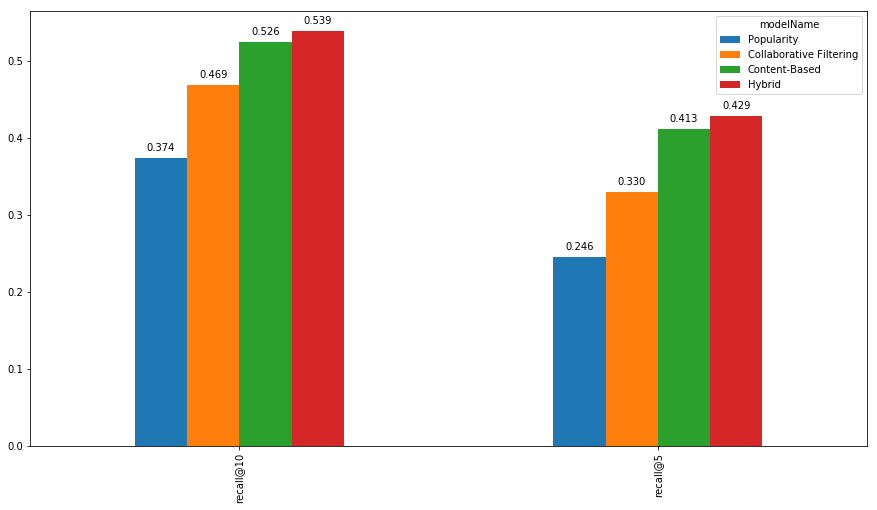

In [80]:
%matplotlib inline
ax = global_metrics_df.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

In [81]:
def inspect_interactions(person_id, test_set=True):
    if test_set:
        interactions_df = interactions_test_indexed_df
    else:
        interactions_df = interactions_train_indexed_df
    return interactions_df.loc[person_id].merge(articles_df, how = 'left', 
                                                      left_on = 'contentId', 
                                                      right_on = 'contentId') \
                          .sort_values('eventStrength', ascending = False)[['eventStrength', 
                                                                          'contentId',
                                                                          'title', 'url', 'lang']]

In [83]:
inspect_interactions(-2979881261169775358, test_set=False).head(20)

,eventStrength,contentId,title,url,lang
201,3.906891,-5148591903395022444,Anti-If: The missing patterns,http://code.joejag.com/2016/anti-if-the-missin...,en
252,3.584963,5847042211895226591,Elastic Stack 5.0.0 Released,https://www.elastic.co/blog/elastic-stack-5-0-...,en
152,3.584963,-790959521412948853,"Microsoft lança Teams, nova plataforma de chat...",https://macmagazine.com.br/2016/11/03/microsof...,pt
138,3.459432,-3191013159715472435,Robô acha de almoço de 12 kg a cervejas pagas ...,http://www.otempo.com.br/capa/pol%C3%ADtica/ro...,pt
92,3.321928,2415534163825594672,Hintjens.com,http://hintjens.com/blog:115,en
325,3.169925,-9192549002213406534,Chrome OS now has Material Design for the desktop,http://thenextweb.com/dd/2016/04/20/googles-ch...,en
74,3.087463,-1453783314552286835,Progressive Web App - first introduced on Goog...,https://flights.airberlin.com/en-DE/progressiv...,en
9,3.087463,-6843047699859121724,"Ganhe 6 meses de acesso ao Pluralsight, maior ...",https://medium.com/@jeffersoncn/ganhe-6-meses-...,pt
289,3.000000,-1418355038507506357,Intel Reveals Its Plan For Blockchain Technolo...,http://www.ibtimes.com/intel-reveals-its-plan-...,en
209,2.700440,957332268361319692,Tasting Dagger 2 on Android,http://fernandocejas.com/2015/04/11/tasting-da...,en


In [85]:
hybrid_recommender_model.recommend_items(-2979881261169775358, topn=20, verbose=True)

,recStrengthHybrid,contentId,title,url,lang
0,0.901081,-5148591903395022444,Anti-If: The missing patterns,http://code.joejag.com/2016/anti-if-the-missin...,en
1,0.770242,-1453783314552286835,Progressive Web App - first introduced on Goog...,https://flights.airberlin.com/en-DE/progressiv...,en
2,0.735489,-2097075598039554565,"The Languages, Frameworks and Tools You Should...",http://tutorialzine.com/2016/12/the-languages-...,en
3,0.628726,-6728844082024523434,Seniority,http://merowing.info/2017/01/seniority/,en
4,0.507511,-8954346068661072425,The technology behind preview photos,https://code.facebook.com/posts/99125254759357...,en
5,0.504673,6062146090334604102,Serverless Data Sync in Web Apps with Bit Torrent,https://paul.kinlan.me/serverless-sync-in-web-...,en
6,0.495417,-4084394822880420062,Android Studio 2.2,http://android-developers.blogspot.com.br/2016...,en
7,0.476376,-8992201526199201450,15 Awesome Sublime Text Plugins For Web Develo...,http://tutorialzine.com/2016/10/15-awesome-sub...,en
8,0.474983,-14569272361926584,Java 8 Streams - A Deeper Approach About Perfo...,http://guirmendes.blogspot.com.br/2017/02/java...,en
9,0.460031,-5920475612630001479,How it feels to learn Javascript in 2016,https://hackernoon.com/how-it-feels-to-learn-j...,en
